In [2]:
import warnings; warnings.simplefilter('ignore')

from scipy.io import wavfile
import pandas as pd
import numpy as np
from plotnine import *
theme_set(theme_bw())
from helper_functions import *

# Expanding your regression repetoire with regularisation
*Classifying drum samples with logistic regression using a large amount of features generated using tsfresh*

## Introduction 
For many data scientists, the basic workhorse model is multiple linear regression. It serves as the first port of call in many analyses, and as the benchmark for more complicated models. One of its strenghts is the easy interpretability of the resulting coefficients, something that especially neural networks struggle with. However, linear regression is not without its challenges. In this article we focus on one particular challenge: dealing with large sets of features. Specific issues with large datasets are how to select the relevant features for our model, how to combat overfitting and how to deal with correlated features. 

[Regularisation](https://en.wikipedia.org/wiki/Regularization_(mathematics)) is a very potent technique that helps with the above mentioned issues. Regularisation does this by expanding the normal least squares goal or loss function with a term which limits the size of coefficients. The main goal of this article is to get you familiar with regularisation and the advantages it offers. 

In this article you will learn about the following topics:

- What regularisation is in more detail and why it is worthwhile to use
- What different types of regularisation there are, and what the terms L1- and L2-norm mean in this context
- How to practically use regularisation 
    - How to generate features for our regularised regression using tsfresh
    - How to interpret and visualise the coefficients of the regularised regression
    - How to optimize the regularisation strength using crossvalidation
    - How to visualise the outcomes of the crossvalidation

We will start this article off with a more theoretical introduction to regularisation, and finish up with a practical example. 

## Why use regularisation and what are norms?
The following figure shows a green and a blue function fitted to the red observations ([attribution](https://commons.wikimedia.org/wiki/File:Regularization.svg)). Both functions perfectly fit the red observations, and we really have no good way of choosing either of the functions using a [loss function](https://en.wikipedia.org/wiki/Loss_function).

![](pics/example_function.png)

Not being able to choose either of these functions means that our problem is *underdetermined*. In regression, [two factors increase the degree of underdetermination](https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net): multicollinearity (correlated features) and the number of features. In a situation with a small amount of handcrafted features this can often be controlled for manually. However, in more data driven approaches often we work with a lot of (correlated) features of which we do not a priori know which ones will work well. To combat undetermination we need to add information to our problem. The mathematical term for adding information to our problem is *regularisation*. 

A very common way in regression to perform regularisation is by expanding the loss function with additional terms. [Tibshirani (1997)](http://statweb.stanford.edu/~tibs/lasso/fulltext.pdf) proposed to add the total size of the coefficients to the loss function in a method called [Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics)). A mathematical way to express the total size of the coefficients is using a so called *norm*:

\begin{equation}
\Vert \mathbf{\beta} \Vert_p = (\sum_i |\beta_i|^p)^{1/p}
\end{equation}

where the p value determines what kind of norm we use. A p value of 1 is called an L1 norm, a value of 2 a L2 norm, etcetera. Now that we have a mathetical epxression for the norm, we can expand the least squares loss function we normally use in regression:

\begin{equation}
L(\beta, \gamma)=\Vert \mathbf{Y} - \mathbf{X\beta} \Vert^2_2 + \lambda \Vert \mathbf{\beta} \Vert_2
\end{equation}

note that we use a L2 norm here, and that we also expressed the squared difference part of the loss function using a L2 norm. In addition, $\lambda$ is the regularisation strength. The regularisation strength determines how strongly the focus will be on limiting coefficient size versus the squared difference part of the loss function. Note that the norm term introduces a bias into the regression, with the major upside of reducing the variance in the model. 

Regression including a L2 norm is called [Ridge regression](https://en.wikipedia.org/wiki/Tikhonov_regularization) ([sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)). Ridge regression reduces the variance in the prediction, making it more stable and less prone to overfitting. In addition, the reduction in variance also [combats the variance introduced by multicollinearity](https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Ridge_Regression.pdf). 

When we add a L1 norm in the loss function, this is called Lasso ([sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)). Lasso goes a step further than Ridge regression in reducing the coefficient size, all the way down to zero. This effectively means that the variable drops out of the model, and thus lasso performs feature selection. This has a large effect when dealing with highly correlated features (multicollinearity). Lasso tends to pick one of the correlated variables, while Ridge regression balances all features. The feature selection property of Lasso is particularly useful when you have a lot of input features of which you do not know in advance which ones will prove beneficial to the model.  

If you want to blend Lasso and Ridge regression, you can add both a L1 and L2 norm to the loss function. This is called [Elastic Net regularisation](https://en.wikipedia.org/wiki/Elastic_net_regularization). With the theoretical part out of the way, let us get into the practical application of regularisation. 

## Example use of regularisation
### The use case
Humans are quite good recognizing sounds. Based on audio alone we are able to distinguish between things like cars, voices, and guns. If someone is particularly experienced they may even be able to tell you what kind of car the sound belongs to. In this example case we will build a regularised [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) model to recognize drum sounds. 

### The dataset
The basis for our model is a set of 75 drum samples, 25 of each type of drum: [kick drum](https://en.wikipedia.org/wiki/Bass_drum), [snare drum](https://en.wikipedia.org/wiki/Snare_drum) and [tom](https://en.wikipedia.org/wiki/Tom-tom_drum). Each drum sample is stored in a wav file, for example:

In [3]:
sample_rate, bass = wavfile.read('./sounds/bass1.wav')
bass_pd = pd.DataFrame(bass, columns=['left', 'right']).assign(time_id = range(len(bass)))
bass_pd.head()

,left,right,time_id
0,7,3,0
1,5,4,1
2,12,7,2
3,86,39,3
4,313,182,4


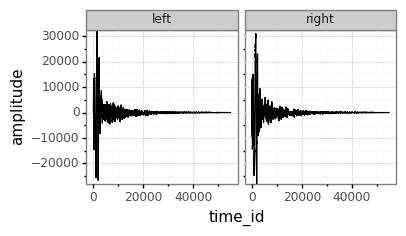

<ggplot: (8763856594705)>

In [4]:
# Note that we use plotnine for all the plots in this article
(
    ggplot(bass_pd.melt(id_vars = ['time_id'], value_name='amplitude', var_name='stereo')) 
      + geom_line(aes(x = 'time_id', 
                      y = 'amplitude'))
      + facet_wrap('stereo') 
      + theme(figure_size=(4,2))
)

The wav file is stereo and contains two channels: left and right. The file contains a waveform over time with time on the x-axis and amplitude on the y-axis. The amplitude essentially lists how the conus of the loudspeaker should vibrate in order to replicate the sound that is stored in the file. 

The following code constructs a DataFrame with all 75 drum samples:

In [5]:
import glob

wav_files = glob.glob('sounds/kick/*.wav') + glob.glob('sounds/snare/*.wav') + glob.glob('sounds/tom/*.wav')
all_audio = pd.concat([audio_to_dataframe(path) for path in wav_files])
all_labels = pd.Series(np.repeat(['kick', 'snare', 'tom'], 25), 
                      index = wav_files)
all_audio.head()

,left,right,time_id,file_id
0,234,252,0,sounds/kick/Industrial-Kick-1.wav
1,157,168,1,sounds/kick/Industrial-Kick-1.wav
2,21,26,2,sounds/kick/Industrial-Kick-1.wav
3,472,499,3,sounds/kick/Industrial-Kick-1.wav
4,-138,-150,4,sounds/kick/Industrial-Kick-1.wav


The extra function `audio_to_dataframe` can be found in the `helper_functions.py` file in the github repo of the article. 

### Generating features using tsfresh
To fit a supervised model, sklearn needs two datasets: a `samples` x `features` matrix (or DataFrame) with our features and a `samples` vector with the labels. As we already have the labels (`all_labels`), we focus our efforts on the feature matrix. As we want our model to make a prediction for each sound file, each row in the feature matrix should contain all features for one sound file. The next challenge then is to come up with the features we want to use. For example, the bass drum probably has more bass frequencies in its sounds. We could therefore run an FFT over all samples and isolate the bass frequency into a feature. 

Taking this manual feature engineering approach can be very labour intensive, and has a strong risk of excluding important features. [tsfresh](https://www.sciencedirect.com/science/article/pii/S0925231218304843) ([docs](https://tsfresh.readthedocs.io/en/latest/text/feature_extraction_settings.html)) is a Python package which greatly speeds this process up. The package generates hundreds of potential features based on timeseries data, and also includes a means to preselect relevant features. Having hundreds of features stresses the importance of using some kind of regularisation in this case. 

To get familiair with tsfresh we first generate a small number of features by using the `MinimalFCParameters` setting:

In [6]:
from tsfresh import extract_relevant_features
from tsfresh.feature_extraction import MinimalFCParameters
settings = MinimalFCParameters()

audio_tsfresh_minimal = extract_relevant_features(all_audio, all_labels, 
                                          column_id='file_id', column_sort='time_id', 
                                          default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 30/30 [00:00<00:00, 190.39it/s]


In [7]:
print(audio_tsfresh_minimal.shape)
audio_tsfresh_minimal.head()

(75, 11)


variable,left__standard_deviation,left__variance,right__standard_deviation,right__variance,right__sum_values,right__mean,left__mean,left__sum_values,left__length,right__length,right__maximum
id,,,,,,,,,,,
sounds/kick/Bass-Drum-1.wav,3657.312984,1.337594e+07,3590.379467,1.289082e+07,-497107.0,-9.002952,-7.925909,-437637.0,55216.0,55216.0,31074.0
sounds/kick/Bass-Drum-2.wav,4075.996590,1.661375e+07,4029.899787,1.624009e+07,-42508.0,-0.721735,-0.886684,-52223.0,58897.0,58897.0,32735.0
sounds/kick/Bass-Drum-3.wav,4292.714980,1.842740e+07,4220.960837,1.781651e+07,-846.0,-0.015398,-0.330755,-18172.0,54941.0,54941.0,32458.0
sounds/kick/Boom-Kick.wav,1998.712897,3.994853e+06,4402.878539,1.938534e+07,-14815.0,-0.182725,-0.022867,-1854.0,81078.0,81078.0,28199.0
sounds/kick/Deep-Kick.wav,5595.344116,3.130788e+07,2279.299347,5.195206e+06,-15080.0,-0.592581,-0.253655,-6455.0,25448.0,25448.0,15711.0


which leaves us with 11 features. We use the `extract_relevant_features` function to allow tsfresh to preselect features that make sense given the labels and potential features generated. In this minimal case, tsfresh looks at each of the sound files as identified by the `file_id` column and generates features such as the standard deviation of the amplitude, the mean amplitude and more. 

But the strength of tsfresh comes when we generate a lot more features. Here we use the efficient settings to save some time in contrast to the complete setting. Note I read the result from a saved pickled DataFrame which has been generated using the `generate_drum_model.py` script available in the github repo. I did this to save time as it takes around 10 minutes on my 12 thread machine to calculate the efficient features. 

In [ ]:
from tsfresh.feature_extraction import EfficientFCParameters
settings = EfficientFCParameters()

audio_tsfresh = pd.read_pickle('pkl/drum_tsfresh.pkl')

In [9]:
print(audio_tsfresh.shape)
audio_tsfresh.head()

(75, 327)


variable,left__absolute_sum_of_changes,"right__agg_autocorrelation__f_agg_""median""__maxlag_40",right__autocorrelation__lag_9,right__autocorrelation__lag_8,right__cid_ce__normalize_True,"right__agg_autocorrelation__f_agg_""mean""__maxlag_40",right__autocorrelation__lag_7,"left__agg_autocorrelation__f_agg_""median""__maxlag_40",left__autocorrelation__lag_9,"left__agg_autocorrelation__f_agg_""mean""__maxlag_40",...,"left__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""var""","right__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.4","left__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.4","right__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""","left__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""min""","left__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""","right__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""min""","left__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.4","left__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""var""","right__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""var"""
id,,,,,,,,,,,,,,,,,,,,,
sounds/kick/Bass-Drum-1.wav,2369429.0,0.976869,0.992087,0.992463,8.032297,0.970193,0.992631,0.976999,0.992364,0.970510,...,-1603.550999,12.674883,23.908925,-1.704951,1.514899,-1.682665,1.465838,10.272774,199.425208,189.836830
sounds/kick/Bass-Drum-2.wav,1208294.0,0.971194,0.992782,0.993574,5.444253,0.963974,0.994348,0.971485,0.992896,0.964321,...,-2153.097448,6.325433,16.589808,-1.160603,1.151189,-1.152499,1.166525,6.248688,433.888494,424.878146
sounds/kick/Bass-Drum-3.wav,2073716.0,0.964921,0.986904,0.987094,10.768677,0.956947,0.987203,0.965498,0.987305,0.957717,...,-2974.954361,8.820384,20.426868,-1.520412,1.465973,-1.538510,1.448172,8.324021,608.722843,602.228481
sounds/kick/Boom-Kick.wav,3701827.0,0.951596,0.970059,0.968890,30.762099,0.950464,0.969476,0.857437,0.868905,0.858785,...,-1862.031063,1.637933,2.990859,-1.684590,0.947862,-0.995347,1.681565,1.291766,316.340723,322.166459
sounds/kick/Deep-Kick.wav,954190.0,0.958096,0.965202,0.963639,10.111833,0.941683,0.963439,0.978634,0.992802,0.971672,...,-7272.848154,1.978070,23.038709,-2.950374,5.865335,-5.678083,3.080818,18.819520,639.134669,389.376734


This greatly expands the number of features from 11 to 327. Now the features include autocorrelation across several possible lags, FFT components and linear and non-linear trends, etcetera, etcetera. These features provide a very expansive learning space for our regularised regression model to work with.   

### Fitting the regularised regression model
Now that we have a set of input features and the required labels, we can go ahead and fit our regularised regression model. We use the logistic regression model from sklearn:

In [10]:
from sklearn.linear_model import LogisticRegression

base_log_reg = LogisticRegression(penalty='l1', 
                                  multi_class='ovr',
                                  solver='saga',
                                  tol=1e-6,
                                  max_iter=int(1e4), 
                                  C=1)

and use the following settings:

- we set the penalty to `l1`, i.e. we use regularisation with a L1 norm.
- we set `multi_class` equal to `one-versus-rest` (`ovr`). This means that our model consists of three sub-models in our case, one for each of the possible types of drums. When predicting with the overall model, we simply choose the model which performs best. 
- we use the `saga` solver to fit our loss function. There are many more available, but saga has a complete set of features. 
- `C` is set to 1 for now, where C equals `1/regularisation strength`. Note that the sklearn Lasso implementation uses $\alpha$, which equals `1/2C`. Because I find $alpha$ a more intuitive measure, we will use that throughout the remainder of the article. 
- `tol` and `max_iter` are set to acceptable defaults. 

Based on these settings we perform a number of experiments. First we will compare the performance of a models based on both the small and larger amount of tsfresh features. After that we will focus on fitting the regularisation strength using crossvalidation, and wrap up with a more general discussion of the performance of the fitted model. 

#### Minimal tsfresh vs efficient
Our first analysis tests the hypothesis that using more generated tsfresh features leads to a better model. To test this, we fit a model using both the minimal and efficient tsfresh features. We judge model performance via the accuracy the model has on a test set. We repeat this 20 times to get a sense for the variance in the accuracy due to the randomness in choosing training and test set:

In [11]:
from sklearn.model_selection import train_test_split

def get_score(audio_data, labels):
    # Replace by cross_val_score?
    audio_train, audio_test, label_train, label_test = train_test_split(audio_data, labels, test_size=0.3)
    log_reg = base_log_reg.fit(audio_train, label_train)
    return log_reg.score(audio_test, label_test)
accuracy_minimal = [get_score(audio_tsfresh_minimal, all_labels) for x in range(20)]
accuracy_efficient = [get_score(audio_tsfresh, all_labels) for x in range(20)]

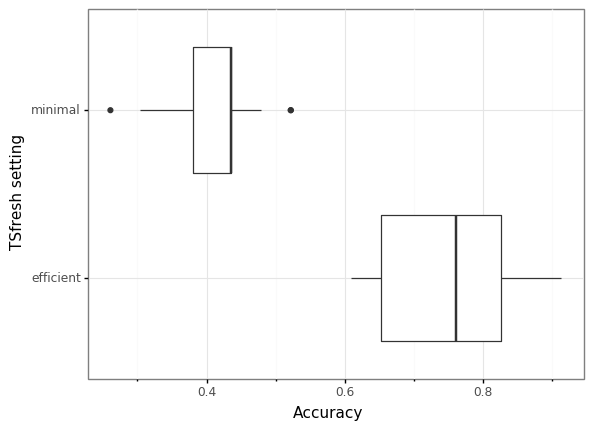

<ggplot: (8763847582261)>

In [12]:
plot_data = pd.concat([pd.DataFrame({'accuracy': accuracy_minimal, 'tsfresh_data': 'minimal'}),
                       pd.DataFrame({'accuracy': accuracy_efficient, 'tsfresh_data': 'efficient'})])
(
    ggplot(plot_data) + geom_boxplot(aes(x='tsfresh_data', y='accuracy')) + 
      coord_flip() + 
      labs(y = 'Accuracy', x = 'TSfresh setting')
)

The resulting boxplot clearly shows that the efficient tsfresh variables show a much higher mean accuracy of 0.75 versus the 0.4 of the minimal features based model. This confirms our hypothesis, and we will use the efficient features in the rest of this article. 

#### Selecting regularisation strength through crossvalidation
One of the major choices we have to make when using regularisation is the regularisation strength. Here we use [crossvalidation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) to test the accuracy of a range of potential values of C. Conviniently, sklearn includes a function which performs this analysis for logistic regression: [`LogisticRegressionCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). It essentially has the same interface as `LogisticRegression`, but you can pass along a list of potential C values to test. For details regarding the code I refer to the `generate_drum_model.py` script on github, and we load the results here from disk to save time:

In [13]:
from sklearn.svm import l1_min_c
from joblib import dump, load

cs = l1_min_c(audio_tsfresh, all_labels, loss='log') * np.logspace(0, 7, 16)
cv_result = load('pkl/drum_logreg_cv.joblib')

Note we use [`l1_min_c`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.l1_min_c.html) to get the minimum C value for which the model will still contains non-zero coefficients. Then we add a log scale between 0 and 7 on top of that to end up with 16 potential C values. Transformed to $\alpha$ regularisation strength and taking the log10 value we end up with:

In [23]:
np.log10(1/(2*cs))

array([8.85011715, 8.38345048, 7.91678381, 7.45011715, 6.98345048,
       6.51678381, 6.05011715, 5.58345048, 5.11678381, 4.65011715,
       4.18345048, 3.71678381, 3.25011715, 2.78345048, 2.31678381,
       1.85011715])

The crossvalidation selected the following $\alpha$ values:

In [14]:
# Selected regularisation strength
np.log10(1/(2*cv_result.C_))

array([6.05011715, 6.05011715, 6.05011715])

Note we have three values, one for each submodel (kick-model, bass-model, snare-model). Here we see that a regularisation strength of around 6 is judged to be optimal (C = `4.5e-07`). 

#### Further interpretation of the model based on CV results
The `cv_result` object contains a lot more data regarding the crossvalidation then the fitted regularisation strength. Here we first look at the coefficients in the crossvalidated models, and what path they followed under changing regularisation strength. Note we use the `plot_coef_paths` function from the `helper_functions.py` file on github:

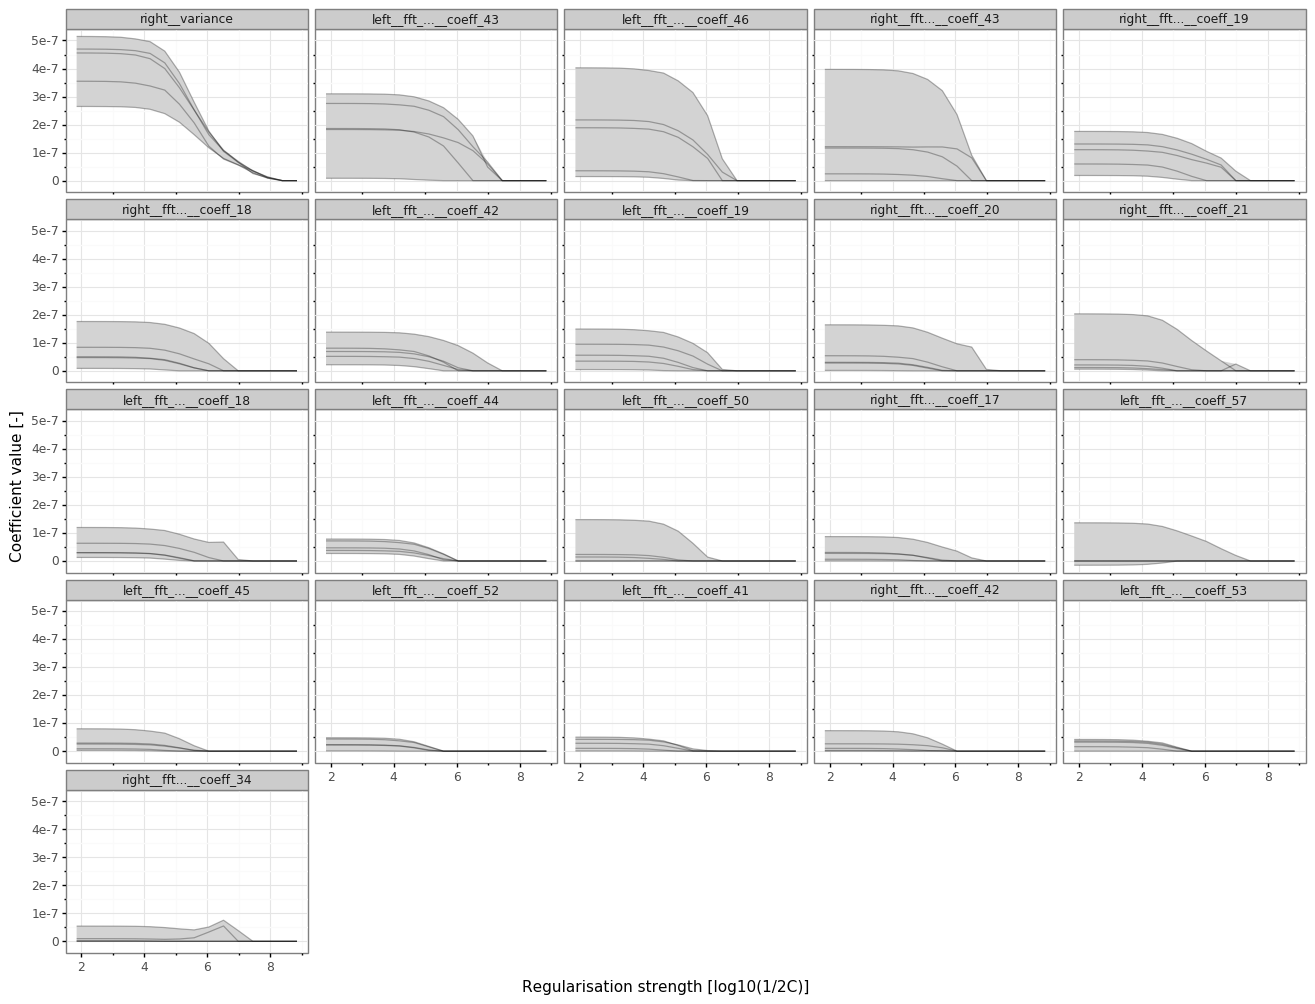

<ggplot: (8763847462033)>

In [15]:
plot_coef_paths(cv_result, 'kick', audio_tsfresh) + theme(figure_size=(16,12))

Note we see 5 lines in the plot as by default we perform 5-fold crossvalidation. In addition, we focus on the `kick` sub-model. The following observations are interesting in this figure:

- Increasing the regularisation strength decreases the size of the coefficients. This is exactly what regularisation is supposed do to, but it is nice that the results support this. 
- Increasing the regularisation strength reduces the variation between the fitted coefficients for the folds (lines are closer together). The is in line with the goal of regularisation: reducing variance in the model and fight underdetermination. However, the variation between folds can still be quite dramatic. 
- The overall coefficient size drops for the later coefficients. So, earlier coefficients are most important in the model. 
- For the crossvalidated regularisation strength (6) quite a number of coefficients drop out of the model. Of the 327 potential features generated by tsfresh, only around 10 are selected for the final model. 
- Many of the influential variables are fft components. This makes sense intuitively as the difference between the drum samples is centered around certain frequencies (bass drum -> low freq, snare -> high freq). 

These observations paint the picture that the regularised regression works as intended, but there is certainly room for improvement. In this case I suspect that having 25 samples of each type of drum is the main limiting factor. 

Apart from looking at the coefficients and how they change, we can also look at the overal accuracy of the sub-models versus the regularisation strength. Note that we use the `plot_reg_strength_vs_score` plot from `helper_functions.py` which you can find on github. 

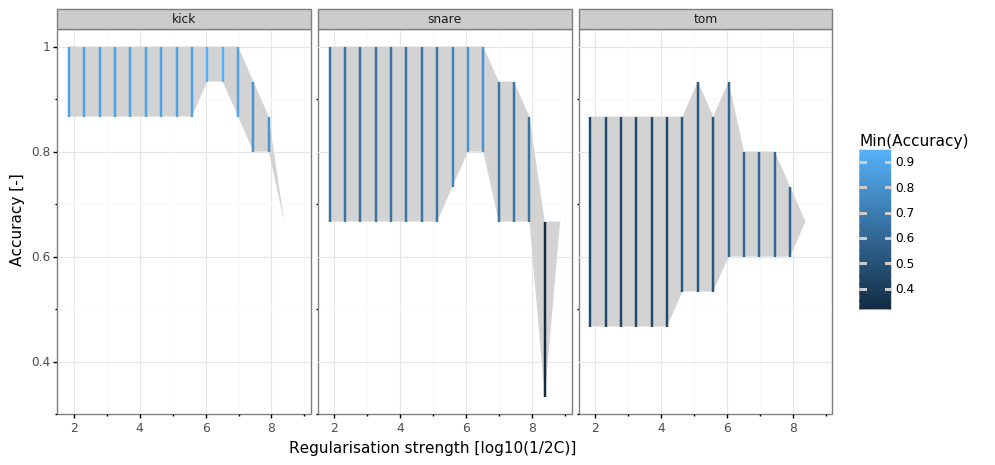

<ggplot: (8763847448261)>

In [16]:
plot_reg_strength_vs_score(cv_result) + theme(figure_size=(10,5))

Note that the accuracy covers not a line but an area because we have an accuracy score for each fold in the crossvalidation. Observations in this figure:

- The kick model performs best overall with a very low minimum accuracy at the fitted regularisation strength (6 -> 0.95).
- The tom model performs worst with a substantially lower minimum and maximum accuracy. 
- Performance peaks between a regularisation strength of 5-6, which is in line with the selected values. With a smaller strength I suspect too much noise from the superfluous variables left in the model, after that the regularisation takes out too much relevant information. 

## Conclusion: performance of our regularised regression model

Based on the accuracy scores from the crossvalidation I conclude that we are quite succesfull at generating a drum sound recognition model. Especially the kick drum is easy to distinguish from the other two drum types. Regularised regression also adds a lot of value to the model, and reduces the overall variance of the model. Finally, tsfresh shows a lot of potential in generating features from these kinds of timeseries based datasets. 

Potential avenues to improve the model are:

- Generate more potential input features using tsfresh. For this analysis I used the efficient settings, but more elaborate settings are possible. 
- Use more drum samples as input to the model. 